In [20]:
#!pip install astroML

In [1]:
#!pip install -U ipympl ipywidgets --force-reinstall

In [428]:
#!pip install cesium==0.12.1

In [430]:
import joblib
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
from astroML.time_series import search_frequencies
from astropy.timeseries import LombScargle

import cesium
from cesium.features.lomb_scargle import lomb_scargle_model, get_lomb_signif
from cesium.featurize import featurize_time_series

%matplotlib inline

In [2]:
cd data/

/Users/jbloom/Projects/AstroML/data


In [3]:
data = joblib.load("macho_raw.pkl")

Data from here:

  https://macho.nci.org.au/macho_photometry/READ_ME

Identifier is field.tile.star number  (eg. 17.2954.38)

Position from here: https://macho.nci.org.au/macho_stars/

   17;2954;38;04:58:33.2534;-69:36:13.4630;(1.30269,-1.21481);E;26;74;73;24;26

In [511]:
def clip_outliers(t, m, merr, max_sigma=5, max_iter=5,
                  measurements_in_flux_units=False,
                  sys_err=0.05, nharm=10, verbose=False, fixed_P=None,
                  max_frac_del=0.15, initial_clip=[100,10]):

    t = t.copy()
    if not measurements_in_flux_units:
        mag0 = np.average(m, weights=1/merr)
        f = 10**(-0.4*(m - mag0))
        ferr = 0.4*np.log(10)*f*merr
        m = m.copy()
        merr = merr.copy()
    else:
        f = m.copy()
        ferr = merr.copy()

    # ensure merr is >= 0 and not nan
    goods = np.squeeze(np.argwhere(~np.isnan(dy) & (dy >= 0)))
    t = t[goods]
    f = f[goods]
    ferr = ferr[goods]
    m = m[goods]
    merr = merr[goods]

    initial_size = len(t)
    max_removed = 0
    if initial_clip is not None:
        med = np.nanmedian(f)
        mad = stats.median_abs_deviation(f, nan_policy="omit")
        if verbose:
            print(f"initial median = {median:0.3f} mad = {mad:0.3f}")
        bads = np.argwhere((f >= initial_clip[1]*mad + med) | (f < med - initial_clip[0]*mad))[:int(max_frac_del * len(f))]
        max_removed += len(bads)
        goods = np.delete(np.arange(len(f)), bads)
        t = t[goods[:]]
        f = f[goods[:]]
        ferr = ferr[goods[:]]
        m = m[goods[:]]
        merr = merr[goods[:]]
        print(f"max_removed (initial cut): {max_removed}")
        
    rez = lomb_scargle_model(t, f, ferr, sys_err=sys_err, nharm=nharm,
                             nfreq=2, tone_control=5.0,default_order=1,
                             freq_grid=None, normalize=False)

    if not fixed_P:
        P = 1 / rez["freq_fits"][0]["freq"]
    else:
        P = fixed_P

    if verbose:
        print(f"iter: 0 ... P: {P} n: {len(t)}")

    iter = 0
    while iter < max_iter:
        # run L-S with 1 freq
        df = 1/5000.00
        f0 = max(1/P - 25*df, df)  # periodogram starting (low) frequency
        fe = 1/P + 25*df  # periodogram ending (high) frequency
        numf = int((fe-f0)/df) + 1
        freq_grid_param = {"f0": f0, "df": df, "fmax": fe, "numf": numf}

        rez = lomb_scargle_model(t, f, ferr, sys_err=sys_err, nharm=nharm,
                                 nfreq=1, tone_control=10.0, default_order=1,
                                 freq_grid=freq_grid_param, normalize=False)

        if not fixed_P:
            P = 1 / rez["freq_fits"][0]["freq"]
        else:
            P = fixed_P

        if verbose:
            print(f"iter: {iter+1} ... P: {P} n: {len(t)}")
        resid = f - rez["freq_fits"][0]["model"]
        resid_err = np.sqrt(ferr**2 + rez["freq_fits"][0]["model_error"]**2)

        # deviation from the model in sigma
        scaled_resid = np.abs(resid)/resid_err
        bads = np.argwhere(scaled_resid >= max_sigma)[:(int(max_frac_del * initial_size) - 1)]
        goods = np.delete(np.arange(len(scaled_resid)), bads)
        if (len(goods) == len(scaled_resid)) or (max_removed > int(max_frac_del * initial_size)):
            # no more outliers to clip
            break

        t = t[goods[:]]
        f = f[goods[:]]
        ferr = ferr[goods[:]]
        m = m[goods[:]]
        merr = merr[goods[:]]
        max_removed += len(bads)
        print(f"max_removed: {max_removed}")

        # run one last time to get the model
        rez = lomb_scargle_model(t, f, ferr, sys_err=sys_err, nharm=nharm,
                                 nfreq=1, tone_control=10.0, default_order=1,
                                 freq_grid=freq_grid_param, normalize=False)

        if not fixed_P:
            P = 1 / rez["freq_fits"][0]["freq"]
        else:
            P = fixed_P
        iter += 1

    if not measurements_in_flux_units:
        y = m
        yerr = merr

        mean_flux_mag = mag0 - 2.5*np.log10(
                               rez["freq_fits"][0]["trend_coef"][0])
        mean_flux_mag_err = 2.5/np.log(10) * \
                            rez["freq_fits"][0]["trend_coef_error"][0]
        rez["freq_fits"][0]["model"] = mag0 - 2.5*np.log10(
                               rez["freq_fits"][0]["model"])
    else:
        y = f
        yerr = ferr
        mean_flux_mag = rez["freq_fits"][0]["trend_coef"][0]
        mean_flux_mag_err = rez["freq_fits"][0]["trend_coef_error"][0]

    return t, y, yerr, rez, P, mean_flux_mag, mean_flux_mag_err, mag0

In [568]:
d = data[4992]
d

LightCurve(times=[48825.6394 48828.8031 48829.8188 ... 51541.4653 51542.735  51544.7339], measurements=[-7.945 -7.838 -8.361 ... -7.846 -8.247 -7.844], errors=[0.022 0.024 0.014 ... 0.021 0.016 0.022], survey=MACHO, name=79.5384.71, best_period=None, best_score=None, label=Ceph Fund, p=2.77928, p_signif=None, p_class=None, ss_resid=0.32317767256024554)

In [566]:
t, y, dy = d.times, d.measurements, d.errors
t, y, yerr, rez, P, mean_flux_mag, mean_flux_mag_err, mag0 = clip_outliers(t, y, dy, max_sigma=4, max_iter=5)
sign = get_lomb_signif(rez)

max_removed (initial cut): 1
max_removed: 26
max_removed: 28
max_removed: 29


Text(0.5, 1.0, 'MACHO 79.5384.71 (Ceph Fund) P=2.7792 d (σ=30.74)')

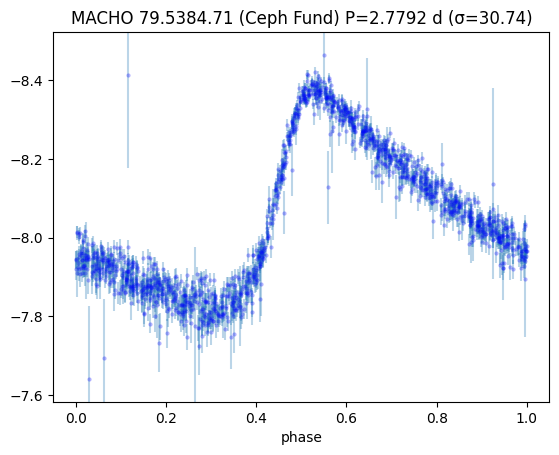

In [567]:
plt.errorbar((t % P) / P, y, yerr, fmt='o', mec="None", mfc="b", ms=3, alpha=0.3)
#plt.scatter((t % P) / P, rez["freq_fits"][0]["model"], c="r", s=2)
plt.xlabel("phase")
plt.ylim(max(y) + np.median(dy)*3,min(y) - np.median(dy)*3)
plt.title(f"MACHO {d.name} ({d.label}) P={P:0.4f} d (σ={sign:0.2f})")

In [543]:
P_min=15/(60*24)
P_max=400
frequency = np.logspace(np.log10(2*np.pi/P_max), np.log10(2*np.pi/P_min), 10000)
frequency = frequency[np.squeeze(np.argwhere(~((frequency > 2*np.pi/1.01) & ( frequency < 2*np.pi/0.99))))]
frequency = frequency[np.squeeze(np.argwhere(~((frequency < 1.01) & ( frequency > 0.99))))]
len(frequency)

9962

In [466]:
power = LombScargle(t, y, yerr).power(frequency)

In [467]:
frequency.shape

(9962,)

In [468]:
best_frequency = frequency[np.argmax(power)]

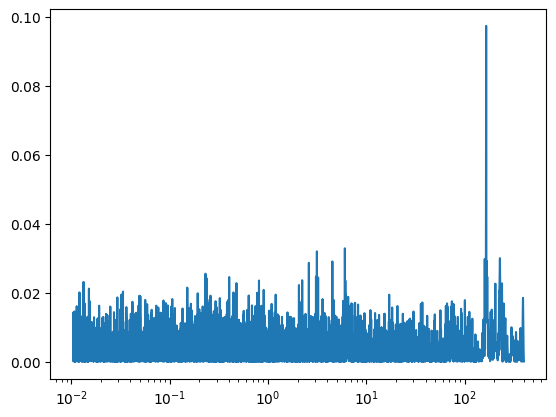

In [469]:
plt.semilogx(2*np.pi/frequency, power)

In [4]:
%run preprocess_data.py --dir=.  --L=200 --use-error

------------before segmenting into L=200------------
['Ceph 1st' 'Ceph Fund' 'EB' 'LPV' 'RRL + GB' 'RRL AB' 'RRL C' 'RRL E']
[ 683 1185 6833 3049  237 7403 1765  315]
------------after segmenting into L=200------------
['Ceph 1st' 'Ceph Fund' 'EB' 'LPV' 'RRL + GB' 'RRL AB' 'RRL C' 'RRL E']
[ 2092  3630 19897  8782   826 22772  5218   903]
Shape of the dataset array: (64120, 200, 3)
Shape of the dataset array: (16049, 200, 3)


In [36]:
%debug

> /Users/jbloom/miniforge3/envs/multi_modal/lib/python3.10/site-packages/numpy/lib/npyio.py(545)save()
    543 
    544     with file_ctx as fid:
--> 545         arr = np.asanyarray(arr)
    546         format.write_array(fid, arr, allow_pickle=allow_pickle,
    547                            pickle_kwargs=dict(fix_imports=fix_imports))



ipdb>  up


> /Users/jbloom/Projects/AstroML/data/preprocess_data.py(464)main()
    462                 f'data/{args.output}/val.pkl')
    463     joblib.dump((x_test, aux_test, label_test), f'data/{args.output}/test.pkl')
--> 464     np.save(f'data/{args.output}/scales.npy', scales_all)
    465 
    466     with open(f'data/{args.output}/info.json', 'w') as f:



ipdb>  scales_all


[0.0, 1.0, array([0.51444719, 0.05404538, 0.31473851]), array([0.91127568, 0.14973043, 0.98775118])]


ipdb>  q
